<a href="https://colab.research.google.com/github/paolo0o0/Orders/blob/main/%D0%9E%D1%82%D1%82%D0%BE%D0%BA_%D0%B2_%D0%A3%D0%A1%D0%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tinkoff
%pip install catboost
import tinkoff as tf
import catboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, precision_score
from catboost import datasets, Pool
from catboost.utils import get_roc_curve, eval_metric
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import top_k_accuracy_score

seed = 42
np.random.seed(seed)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train = train[train['current_status'] == 1]
train['status'] = (train['status'].fillna(-1)).astype(int)
train = train[train['status'] != -1]

test = test[test['current_status'] == 1]
test['status'] = (test['status'].fillna(-1)).astype(int)
test = test[test['status'] != -1]

# Берем для теста 3 месяца
test_first = test[test['dt'] == '2024-02-01']
test_second = test[test['dt'] == '2024-03-01']
test_third = test[test['dt'] == '2024-04-01']

print(train.shape, test_first.shape, test_second.shape, test_third.shape)

# train - весь обучающий датасет, test first, second, third - данные для теста модели

#train.sort_values(by=['id', 'dt'], ascending=True).head(50)
train[train['status'] == 0].head(50)

(123223, 22) (12934, 22) (12911, 22) (13018, 22)


,dt,current_status,id,total_meetings,cnt_month,total_agent_type,sell_agent_type,contractor,region_group,core_grade,...,count_top_periods_total,count_middle_periods_total,private_flg,meeting_rating,activeness_rating,cc_sales_rating,dc_sales_rating,trd_sales_rating,sim_sales_rating,status
5,2023-06-01,1,172979.0,4734.0,15.0,middle,middle,CONTRACTOR,Москва,4.973000,...,0.000000,15.500000,0.0,87.513333,37.466667,4.596667,6.013333,16.606667,18.673333,0
47,2023-10-01,1,292932.0,1424.0,4.0,middle,middle,SELFEMPLOYED,Москва,4.800500,...,0.000000,2.500000,0.0,64.825806,55.516129,9.241935,6.512903,7.454839,3.451613,0
48,2024-01-01,1,322361.0,622.0,2.0,low,low,CONTRACTOR,>300 вст/д,4.967333,...,0.000000,1.666667,0.0,56.558065,14.258065,5.522581,41.554839,0.000000,16.806452,0
68,2023-08-01,1,211702.0,3441.0,12.0,low,low,CONTRACTOR,>100 вст/д,4.946500,...,0.000000,20.000000,0.0,75.441935,22.870968,15.796774,13.651613,0.000000,23.567742,0
69,2024-01-01,1,330030.0,137.0,1.0,middle,middle,CONTRACTOR,Москва,5.000000,...,0.000000,3.000000,0.0,90.490323,21.838710,17.612903,15.106452,5.587097,18.029032,0
107,2023-12-01,1,333634.0,1.0,0.0,middle,middle,CONTRACTOR,Другие миллионники,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
111,2023-10-01,1,321155.0,3.0,0.0,middle,middle,CONTRACTOR,Санкт-Петербург,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
159,2023-09-01,1,44802.0,13032.0,44.0,low,low,CONTRACTOR,>300 вст/д,4.976000,...,2.000000,11.000000,0.0,69.533333,13.000000,14.400000,9.783333,1.000000,11.206667,0
163,2023-12-01,1,326522.0,155.0,1.0,new,new,CONTRACTOR,>300 вст/д,5.000000,...,0.000000,1.500000,0.0,70.148387,38.000000,15.522581,19.103226,5.164516,18.164516,0
175,2023-10-01,1,301823.0,655.0,2.0,low,low,CONTRACTOR,<30 вст/д,5.000000,...,0.000000,2.000000,0.0,84.867742,61.000000,3.658065,0.000000,0.000000,15.280645,0


In [ ]:
train['dt'] = train['dt'].str[:7].astype(str)
test_first['dt'] = test_first['dt'].str[:7].astype(str)
test_second['dt'] = test_second['dt'].str[:7].astype(str)
test_third['dt'] = test_third['dt'].str[:7].astype(str)

train['dt'].unique(), test_first['dt'].unique(), test_second['dt'].unique(), test_third['dt'].unique()

/var/folders/9r/qmhsw69x2n3c899zl4l06bnc0000gq/T/ipykernel_78205/895628556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_first['dt'] = test_first['dt'].str[:7].astype(str)
/var/folders/9r/qmhsw69x2n3c899zl4l06bnc0000gq/T/ipykernel_78205/895628556.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_second['dt'] = test_second['dt'].str[:7].astype(str)
/var/folders/9r/qmhsw69x2n3c899zl4l06bnc0000gq/T/ipykernel_78205/895628556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

(array(['2023-05', '2023-06', '2023-07', '2023-11', '2023-09', '2023-10',
        '2023-08', '2023-12', '2024-01', '2024-02'], dtype=object),
 array(['2024-02'], dtype=object),
 array(['2024-03'], dtype=object),
 array(['2024-04'], dtype=object))

In [ ]:
cat_features = ['contractor', 'region_group', 'total_agent_type', 'sell_agent_type']
num_features = ['total_meetings', 'cnt_month', 'core_grade', 'violations',
                'count_top_periods_total', 'count_middle_periods_total', 'private_flg',
                'total_core_rating','meeting_rating', 'activeness_rating', 'cc_sales_rating',
                'dc_sales_rating', 'trd_sales_rating', 'sim_sales_rating']

num_festures_previous = ['total_meetings', 'cnt_month', 'core_grade', 'private_flg',
                        'total_core_rating','meeting_rating', 'activeness_rating']
#19 фичей

In [ ]:
train = train.sort_values('dt')
test_first = test_first.sort_values('dt')
test_second = test_second.sort_values('dt')
test_third = test_third.sort_values('dt')

y = (train['status'] == 0).astype(int)
y_test_first = (test_first['status'] == 0).astype(int)
y_test_second = (test_second['status'] == 0).astype(int)
y_test_third = (test_third['status'] == 0).astype(int)

X = train.drop(['status', 'id'], axis=1)
X_test_first = test_first.drop(['status', 'id'], axis=1)
X_test_second = test_second.drop(['status', 'id'], axis=1)
X_test_third = test_third.drop(['status', 'id'], axis=1)

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

X_test_first = X_test_first.reset_index(drop=True)
y_test_first = y_test_first.reset_index(drop=True)

X_test_second = X_test_second.reset_index(drop=True)
y_test_second = y_test_second.reset_index(drop=True)

X_test_third = X_test_third.reset_index(drop=True)
y_test_third = y_test_third.reset_index(drop=True)

In [ ]:
def precision_at_k(y_true, y_pred, k):
  top_k_predictions = np.argsort(y_pred)[-k:]
  correct_predictions = np.sum(np.isin(y_true[-k:], top_k_predictions))
  precision_at_k = correct_predictions / k
  return precision_at_k

In [ ]:
tscv = TimeSeriesSplit(n_splits=len(X['dt'].unique()) - 1)
weight_0 = 1
weight_1 = 1.5
weight_dict = {0: weight_0, 1: weight_1}
base_model = CatBoostClassifier(random_seed=seed, early_stopping_rounds=50,
                                class_weights=weight_dict)
# logreg = LogisticRegression(penalty='elasticnet', class_weight='balanced',
#                             solver='saga', random_state=seed, l1_ratio=0.5)

f1_scores = []
recall_scores = []
precision_scores = []
roc_auc_scores = []
confusion_matrix_scores = []

# f1_scores_logreg = []
# recall_scores_logreg = []
# precision_scores_logreg = []
# roc_auc_scores_logreg = []
# confusion_matrix_scores_logreg = []

for i, (train_index, test_index) in enumerate(tscv.split(X, y)):
    print(f'Fold {i}')
    X_tr, X_te = X.loc[train_index], X.loc[test_index]
    y_tr, y_te = y.loc[train_index], y.loc[test_index]
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

    X_tr = X_tr.drop(['dt'], axis=1)
    X_te = X_te.drop(['dt'], axis=1)

    # Обучим бустинг
    base_model.fit(X_tr, y_tr, cat_features=cat_features,
                   eval_set=(X_te, y_te), use_best_model=True, plot=True)
    y_predicted = base_model.predict(X_te)
    y_predicted_prob = base_model.predict_proba(X_te)
    y_prob = y_predicted_prob[:, 1]

    #Обучим лог регрессию
#     X_tr_num = pd.DataFrame(X_tr[num_features])
#     X_tr_cat = pd.DataFrame(X_tr[cat_features])
#     X_te_num = pd.DataFrame(X_te[num_features])
#     X_te_cat = pd.DataFrame(X_te[cat_features])

#     print(y_te.shape, X_te.shape)

#     encoder_tr = OneHotEncoder(sparse=False, handle_unknown='error')
#     X_tr_cat_encoded = pd.DataFrame(encoder_tr.fit_transform(X_tr_cat))
#     X_tr_encoded = pd.concat([X_tr_cat_encoded, X_tr_num], axis=1)
#     X_tr_encoded = X_tr_encoded.fillna(0)

#     encoder_te = OneHotEncoder(sparse=False, handle_unknown='error')
#     X_te_cat_encoded = pd.DataFrame(encoder_te.fit_transform(X_te_cat))
#     print(len(X_te_cat_encoded))
#     X_te_encoded = pd.merge(X_te_cat_encoded, X_te_num, left_index=True, right_index=True)
#     print(len(X_te_encoded))
#     X_te_encoded = X_te_encoded.fillna(0)
#     X_te_encoded = X_te_encoded.drop([20], axis=1)

#     logreg.fit(X_tr_encoded, y_tr)
#     logreg_y_predicted = logreg.predict(X_te_encoded)
#     logreg_y_predicted_proba = logreg.predict_proba(X_te_encoded)[:, 1]

#     print(len(y_te), len(X_te_encoded))
#     print(len(y_te), len(logreg_y_predicted))

    #Предсказание для бустинга
    f1_score = metrics.f1_score(y_te, y_predicted)
    recall_score_ = metrics.recall_score(y_te, y_predicted)
    precision_score_ = metrics.precision_score(y_te, y_predicted)
    roc_auc_score_ = metrics.roc_auc_score(y_te, y_prob)
    confusion_matrix_score_ = metrics.confusion_matrix(y_te, y_predicted)

    print(f'f1 score catboost: {f1_score}')
    print(f'recall score catboost: {recall_score_}')
    print(f'precision score catboost: {precision_score_}')
    print(f'roc auc score catboost: {roc_auc_score_}')
    print(f'confusion matrix catboost: {confusion_matrix_score_}')
    print('----------------')

    f1_scores.append(f1_score)
    recall_scores.append(recall_score_)
    precision_scores.append(precision_score_)
    roc_auc_scores.append(roc_auc_score_)
    confusion_matrix_scores.append(confusion_matrix_score_)

    #Предсказание для лог регрессии
#     f1_score_logreg = metrics.f1_score(y_te, logreg_y_predicted)
#     recall_score_logreg = metrics.recall_score(y_te, logreg_y_predicted)
#     precision_score_logreg = metrics.precision_score(y_te, logreg_y_predicted)
#     roc_auc_score_logreg = metrics.roc_auc_score(y_te, logreg_y_predicted_proba)
#     confusion_matrix_score_logreg = metrics.confusion_matrix(y_te, logreg_y_predicted)

#     print(f'f1 score logreg: {f1_score_logreg}')
#     print(f'recall score logreg: {recall_score_logreg}')
#     print(f'precision score logreg: {precision_score_logreg}')
#     print(f'roc auc score logreg: {roc_auc_score_logreg}')
#     print(f'confusion matrix logreg: {confusion_matrix_score_logreg}')
#     print('----------------')

#     f1_scores_logreg.append(f1_score_logreg)
#     recall_scores_logreg.append(recall_score_logreg)
#     precision_scores_logreg.append(precision_score_logreg)
#     roc_auc_scores_logreg.append(roc_auc_score_logreg)
#     confusion_matrix_scores_logreg.append(confusion_matrix_score_logreg)


Fold 0
  Train: index=[    0     1     2 ... 12322 12323 12324]
  Test:  index=[12325 12326 12327 ... 24644 24645 24646]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.05893
0:	learn: 0.6364500	test: 0.6340640	best: 0.6340640 (0)	total: 12.8ms	remaining: 12.7s
1:	learn: 0.5881969	test: 0.5841923	best: 0.5841923 (1)	total: 22.5ms	remaining: 11.2s
2:	learn: 0.5476436	test: 0.5421028	best: 0.5421028 (2)	total: 29.1ms	remaining: 9.69s
3:	learn: 0.5130617	test: 0.5066221	best: 0.5066221 (3)	total: 39.7ms	remaining: 9.88s
4:	learn: 0.4847033	test: 0.4778249	best: 0.4778249 (4)	total: 47.1ms	remaining: 9.37s
5:	learn: 0.4595385	test: 0.4526886	best: 0.4526886 (5)	total: 54ms	remaining: 8.94s
6:	learn: 0.4395336	test: 0.4322604	best: 0.4322604 (6)	total: 60.1ms	remaining: 8.53s
7:	learn: 0.4200403	test: 0.4117592	best: 0.4117592 (7)	total: 66.8ms	remaining: 8.28s
8:	learn: 0.4047295	test: 0.3961553	best: 0.3961553 (8)	total: 73.1ms	remaining: 8.05s
9:	learn: 0.3911690	test: 0.3824904	best: 0.3824904 (9)	total: 79.7ms	remaining: 7.89s
10:	learn: 0.3788073	test: 0.3701293	best: 0.3701293 (10)	total: 86.7ms	remaining: 7.8s
11:	learn: 0.36

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.069932
0:	learn: 0.6243606	test: 0.6247739	best: 0.6247739 (0)	total: 13ms	remaining: 13s
1:	learn: 0.5687526	test: 0.5664724	best: 0.5664724 (1)	total: 24.9ms	remaining: 12.4s
2:	learn: 0.5256522	test: 0.5168029	best: 0.5168029 (2)	total: 37.3ms	remaining: 12.4s
3:	learn: 0.4884805	test: 0.4776949	best: 0.4776949 (3)	total: 49.1ms	remaining: 12.2s
4:	learn: 0.4564869	test: 0.4449512	best: 0.4449512 (4)	total: 60.2ms	remaining: 12s
5:	learn: 0.4312814	test: 0.4186144	best: 0.4186144 (5)	total: 71.2ms	remaining: 11.8s
6:	learn: 0.4102884	test: 0.3962125	best: 0.3962125 (6)	total: 82.4ms	remaining: 11.7s
7:	learn: 0.3953759	test: 0.3807138	best: 0.3807138 (7)	total: 93.6ms	remaining: 11.6s
8:	learn: 0.3808867	test: 0.3658654	best: 0.3658654 (8)	total: 107ms	remaining: 11.8s
9:	learn: 0.3684549	test: 0.3523425	best: 0.3523425 (9)	total: 116ms	remaining: 11.5s
10:	learn: 0.3579967	test: 0.3419723	best: 0.3419723 (10)	total: 126ms	remaining: 11.3s
11:	learn: 0.3482097

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.077297
0:	learn: 0.6175105	test: 0.6175595	best: 0.6175595 (0)	total: 16.1ms	remaining: 16.1s
1:	learn: 0.5563099	test: 0.5542910	best: 0.5542910 (1)	total: 35ms	remaining: 17.5s
2:	learn: 0.5092918	test: 0.5074156	best: 0.5074156 (2)	total: 47.4ms	remaining: 15.8s
3:	learn: 0.4695499	test: 0.4672766	best: 0.4672766 (3)	total: 60.3ms	remaining: 15s
4:	learn: 0.4375852	test: 0.4359235	best: 0.4359235 (4)	total: 74.9ms	remaining: 14.9s
5:	learn: 0.4116485	test: 0.4102160	best: 0.4102160 (5)	total: 88.4ms	remaining: 14.7s
6:	learn: 0.3908834	test: 0.3892130	best: 0.3892130 (6)	total: 104ms	remaining: 14.8s
7:	learn: 0.3748770	test: 0.3733014	best: 0.3733014 (7)	total: 118ms	remaining: 14.6s
8:	learn: 0.3598350	test: 0.3583263	best: 0.3583263 (8)	total: 131ms	remaining: 14.4s
9:	learn: 0.3477683	test: 0.3461298	best: 0.3461298 (9)	total: 148ms	remaining: 14.7s
10:	learn: 0.3391012	test: 0.3382527	best: 0.3382527 (10)	total: 161ms	remaining: 14.5s
11:	learn: 0.3310097

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.082989
0:	learn: 0.6142125	test: 0.6133506	best: 0.6133506 (0)	total: 17.9ms	remaining: 17.9s
1:	learn: 0.5490953	test: 0.5486322	best: 0.5486322 (1)	total: 34ms	remaining: 17s
2:	learn: 0.5026821	test: 0.5058062	best: 0.5058062 (2)	total: 51.9ms	remaining: 17.2s
3:	learn: 0.4617817	test: 0.4655959	best: 0.4655959 (3)	total: 71.3ms	remaining: 17.7s
4:	learn: 0.4278887	test: 0.4325783	best: 0.4325783 (4)	total: 89.8ms	remaining: 17.9s
5:	learn: 0.4018556	test: 0.4071868	best: 0.4071868 (5)	total: 107ms	remaining: 17.7s
6:	learn: 0.3808245	test: 0.3871825	best: 0.3871825 (6)	total: 123ms	remaining: 17.4s
7:	learn: 0.3656031	test: 0.3730085	best: 0.3730085 (7)	total: 139ms	remaining: 17.2s
8:	learn: 0.3520803	test: 0.3595206	best: 0.3595206 (8)	total: 157ms	remaining: 17.3s
9:	learn: 0.3416458	test: 0.3504056	best: 0.3504056 (9)	total: 174ms	remaining: 17.2s
10:	learn: 0.3332044	test: 0.3427849	best: 0.3427849 (10)	total: 190ms	remaining: 17.1s
11:	learn: 0.3251167	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.087692
0:	learn: 0.6123878	test: 0.6168369	best: 0.6168369 (0)	total: 23.1ms	remaining: 23.1s
1:	learn: 0.5482761	test: 0.5535896	best: 0.5535896 (1)	total: 43.9ms	remaining: 21.9s
2:	learn: 0.4965164	test: 0.5039210	best: 0.5039210 (2)	total: 65.1ms	remaining: 21.6s
3:	learn: 0.4556163	test: 0.4667628	best: 0.4667628 (3)	total: 83.7ms	remaining: 20.8s
4:	learn: 0.4238837	test: 0.4376008	best: 0.4376008 (4)	total: 105ms	remaining: 20.9s
5:	learn: 0.3981804	test: 0.4133113	best: 0.4133113 (5)	total: 124ms	remaining: 20.6s
6:	learn: 0.3774653	test: 0.3949703	best: 0.3949703 (6)	total: 146ms	remaining: 20.7s
7:	learn: 0.3607399	test: 0.3796271	best: 0.3796271 (7)	total: 165ms	remaining: 20.5s
8:	learn: 0.3474232	test: 0.3687508	best: 0.3687508 (8)	total: 183ms	remaining: 20.1s
9:	learn: 0.3373660	test: 0.3608291	best: 0.3608291 (9)	total: 203ms	remaining: 20.1s
10:	learn: 0.3290414	test: 0.3538653	best: 0.3538653 (10)	total: 222ms	remaining: 19.9s
11:	learn: 0.32207

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.091731
0:	learn: 0.6100481	test: 0.6105783	best: 0.6105783 (0)	total: 27.7ms	remaining: 27.6s
1:	learn: 0.5438725	test: 0.5419203	best: 0.5419203 (1)	total: 52.9ms	remaining: 26.4s
2:	learn: 0.4938654	test: 0.4905101	best: 0.4905101 (2)	total: 76.7ms	remaining: 25.5s
3:	learn: 0.4534143	test: 0.4491314	best: 0.4491314 (3)	total: 99.5ms	remaining: 24.8s
4:	learn: 0.4218891	test: 0.4173709	best: 0.4173709 (4)	total: 130ms	remaining: 25.9s
5:	learn: 0.3970205	test: 0.3913817	best: 0.3913817 (5)	total: 153ms	remaining: 25.3s
6:	learn: 0.3787463	test: 0.3722550	best: 0.3722550 (6)	total: 175ms	remaining: 24.8s
7:	learn: 0.3629466	test: 0.3552964	best: 0.3552964 (7)	total: 195ms	remaining: 24.2s
8:	learn: 0.3512345	test: 0.3424763	best: 0.3424763 (8)	total: 217ms	remaining: 23.9s
9:	learn: 0.3415472	test: 0.3322380	best: 0.3322380 (9)	total: 238ms	remaining: 23.6s
10:	learn: 0.3337679	test: 0.3236174	best: 0.3236174 (10)	total: 256ms	remaining: 23s
11:	learn: 0.3270441

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.095291
0:	learn: 0.6027858	test: 0.5997803	best: 0.5997803 (0)	total: 31.1ms	remaining: 31.1s
1:	learn: 0.5356213	test: 0.5290407	best: 0.5290407 (1)	total: 54ms	remaining: 26.9s
2:	learn: 0.4832701	test: 0.4733275	best: 0.4733275 (2)	total: 76.9ms	remaining: 25.5s
3:	learn: 0.4432746	test: 0.4293978	best: 0.4293978 (3)	total: 102ms	remaining: 25.5s
4:	learn: 0.4116903	test: 0.3948719	best: 0.3948719 (4)	total: 126ms	remaining: 25.2s
5:	learn: 0.3885942	test: 0.3699217	best: 0.3699217 (5)	total: 151ms	remaining: 24.9s
6:	learn: 0.3695031	test: 0.3480840	best: 0.3480840 (6)	total: 171ms	remaining: 24.3s
7:	learn: 0.3546309	test: 0.3317236	best: 0.3317236 (7)	total: 196ms	remaining: 24.3s
8:	learn: 0.3426707	test: 0.3171790	best: 0.3171790 (8)	total: 228ms	remaining: 25.1s
9:	learn: 0.3330900	test: 0.3057200	best: 0.3057200 (9)	total: 258ms	remaining: 25.5s
10:	learn: 0.3257768	test: 0.2973120	best: 0.2973120 (10)	total: 281ms	remaining: 25.3s
11:	learn: 0.3197908	

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.098486
0:	learn: 0.5995825	test: 0.5996202	best: 0.5996202 (0)	total: 29.9ms	remaining: 29.8s
1:	learn: 0.5263778	test: 0.5203759	best: 0.5203759 (1)	total: 60.4ms	remaining: 30.1s
2:	learn: 0.4725175	test: 0.4637716	best: 0.4637716 (2)	total: 95ms	remaining: 31.6s
3:	learn: 0.4321394	test: 0.4223918	best: 0.4223918 (3)	total: 124ms	remaining: 31s
4:	learn: 0.4017350	test: 0.3900676	best: 0.3900676 (4)	total: 158ms	remaining: 31.4s
5:	learn: 0.3773542	test: 0.3620548	best: 0.3620548 (5)	total: 190ms	remaining: 31.5s
6:	learn: 0.3584645	test: 0.3412611	best: 0.3412611 (6)	total: 223ms	remaining: 31.7s
7:	learn: 0.3455496	test: 0.3263747	best: 0.3263747 (7)	total: 263ms	remaining: 32.6s
8:	learn: 0.3337258	test: 0.3128271	best: 0.3128271 (8)	total: 294ms	remaining: 32.4s
9:	learn: 0.3245729	test: 0.3026816	best: 0.3026816 (9)	total: 323ms	remaining: 32s
10:	learn: 0.3177155	test: 0.2946898	best: 0.2946898 (10)	total: 351ms	remaining: 31.6s
11:	learn: 0.3122261	test

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.101393
0:	learn: 0.5953791	test: 0.5973145	best: 0.5973145 (0)	total: 27.1ms	remaining: 27s
1:	learn: 0.5259219	test: 0.5244645	best: 0.5244645 (1)	total: 56.1ms	remaining: 28s
2:	learn: 0.4702338	test: 0.4672396	best: 0.4672396 (2)	total: 86.3ms	remaining: 28.7s
3:	learn: 0.4295379	test: 0.4279953	best: 0.4279953 (3)	total: 114ms	remaining: 28.4s
4:	learn: 0.3975333	test: 0.3958995	best: 0.3958995 (4)	total: 151ms	remaining: 30.1s
5:	learn: 0.3738007	test: 0.3717822	best: 0.3717822 (5)	total: 179ms	remaining: 29.6s
6:	learn: 0.3550733	test: 0.3525070	best: 0.3525070 (6)	total: 210ms	remaining: 29.8s
7:	learn: 0.3400706	test: 0.3381314	best: 0.3381314 (7)	total: 240ms	remaining: 29.7s
8:	learn: 0.3284396	test: 0.3261515	best: 0.3261515 (8)	total: 270ms	remaining: 29.7s
9:	learn: 0.3189553	test: 0.3169891	best: 0.3169891 (9)	total: 301ms	remaining: 29.8s
10:	learn: 0.3121269	test: 0.3104502	best: 0.3104502 (10)	total: 339ms	remaining: 30.5s
11:	learn: 0.3064456	te

In [ ]:
print(f1_scores)
print('--------------------------------')
print(recall_scores)
print('--------------------------------')
print(precision_scores)
print('--------------------------------')
print(roc_auc_scores)
print('--------------------------------')
print(confusion_matrix_scores)
print('--------------------------------')

[0.01834862385321101, 0.029411764705882356, 0.026875699888017916, 0.06294416243654823, 0.10389610389610389, 0.15151515151515152, 0.20913705583756345, 0.2145922746781116, 0.1470888661899898]
--------------------------------
[0.009324009324009324, 0.015132408575031526, 0.013714285714285714, 0.033155080213903745, 0.055762081784386616, 0.0866738894907909, 0.12232779097387174, 0.1278772378516624, 0.08323699421965318]
--------------------------------
[0.5714285714285714, 0.5217391304347826, 0.6666666666666666, 0.62, 0.759493670886076, 0.6015037593984962, 0.7202797202797203, 0.6666666666666666, 0.631578947368421]
--------------------------------
[0.7585769661833862, 0.7768642964826785, 0.7700207914737486, 0.7531684268907831, 0.7646413065826957, 0.8195067480877084, 0.8509274624049261, 0.8113645077502027, 0.7774859098685661]
--------------------------------
[array([[11458,     6],
       [  850,     8]]), array([[11518,    11],
       [  781,    12]]), array([[11441,     6],
       [  863,    1

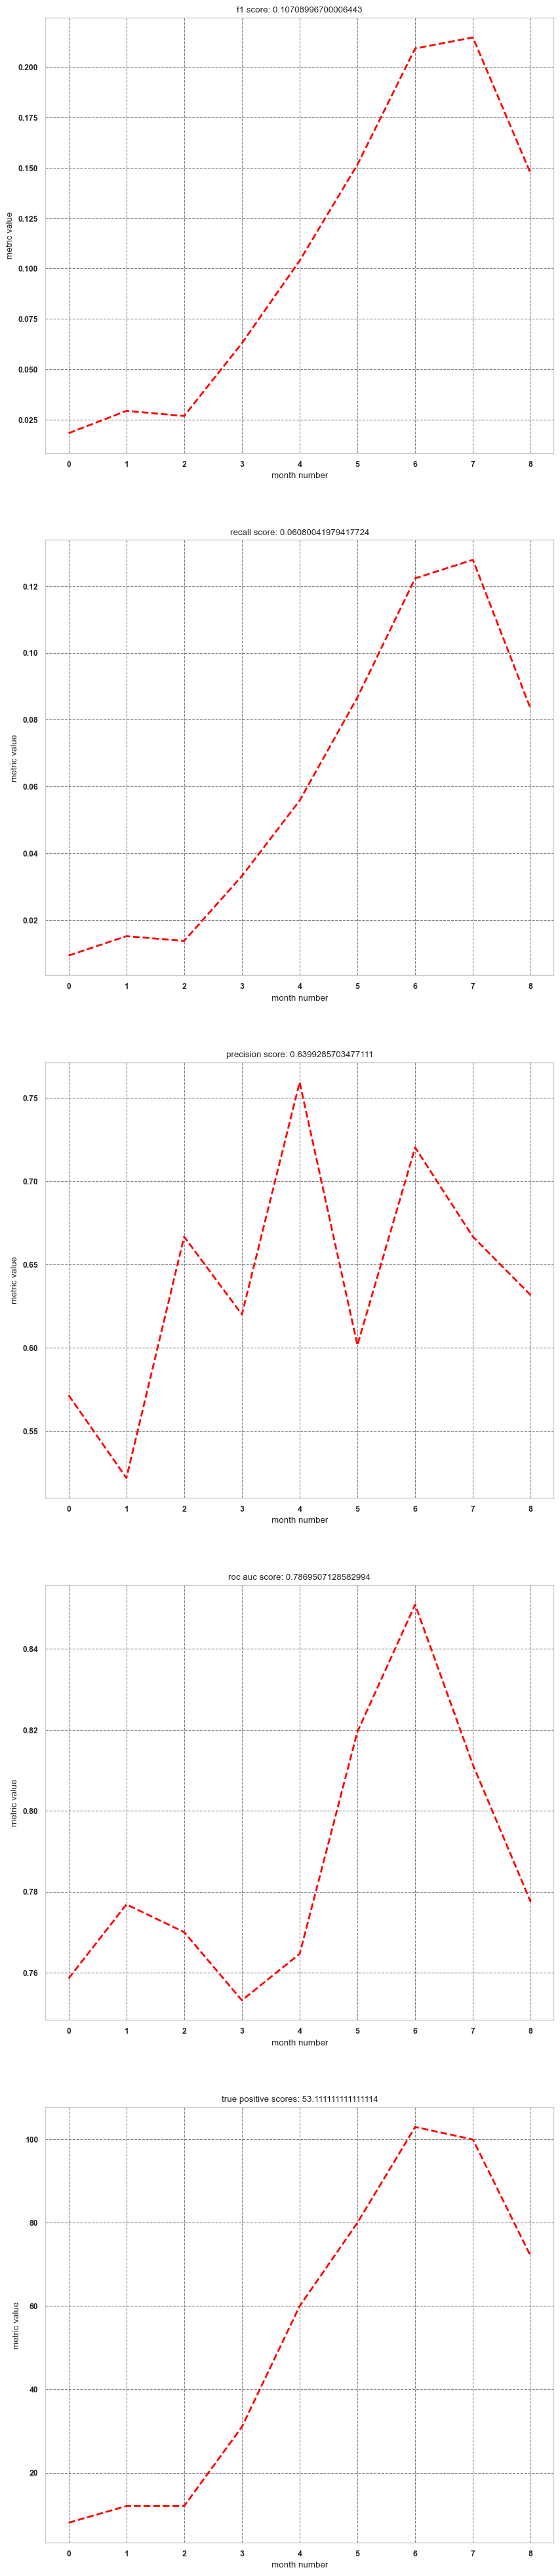

In [ ]:
true_positive_scores = []
for matrix in confusion_matrix_scores:
    true_positive_scores.append(matrix[1][1])

fig, axes = plt.subplots(5, 1, figsize=(10, 50))
metrics_dict = {'f1 score': f1_scores, 'recall score': recall_scores,
           'precision score': precision_scores, 'roc auc score':roc_auc_scores,
           'true positive scores': true_positive_scores}

for k, metric in enumerate(metrics_dict.keys()):
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.weight'] = 'bold'

    axes[k].grid(color='gray', linestyle='--')
    axes[k].set_xlabel("month number")
    axes[k].set_ylabel("metric value")
    axes[k].set_title(f'{metric}: {np.mean(metrics_dict[metric])}')

    sns.set_style("whitegrid")
    sns.set_palette("muted")
    sns.set_context("paper")
    axes[k].plot(np.arange(0, len(metrics_dict[metric])), metrics_dict[metric],
                 color='red', linewidth=2, linestyle='--')


In [ ]:
#Сделаем и протестируем предсказание на май 2024
X_test_first = X_test_first.drop(['dt'], axis=1)
X_test_second = X_test_second.drop(['dt'], axis=1)
X_test_third = X_test_third.drop(['dt'], axis=1)

y_test_predicted_first = base_model.predict(X_test_first)
y_test_predicted_proba_first = base_model.predict_proba(X_test_first)
y_test_predicted_proba_first = y_test_predicted_proba_first[:, 1]

y_test_predicted_second = base_model.predict(X_test_second)
y_test_predicted_proba_second = base_model.predict_proba(X_test_second)
y_test_predicted_proba_second = y_test_predicted_proba_second[:, 1]

y_test_predicted_third = base_model.predict(X_test_third)
y_test_predicted_proba_third = base_model.predict_proba(X_test_third)
y_test_predicted_proba_third = y_test_predicted_proba_third[:, 1]

f1_score_test_first = metrics.f1_score(y_test_first, y_test_predicted_first)
recall_score_test_first = metrics.recall_score(y_test_first, y_test_predicted_first)
precision_score_test_first = metrics.precision_score(y_test_first, y_test_predicted_first)
roc_auc_score_test_first = metrics.roc_auc_score(y_test_first, y_test_predicted_proba_first)
confusion_matrix_score_test_first = metrics.confusion_matrix(y_test_first, y_test_predicted_first)

f1_score_test_second = metrics.f1_score(y_test_second, y_test_predicted_second)
recall_score_test_second = metrics.recall_score(y_test_second, y_test_predicted_second)
precision_score_test_second = metrics.precision_score(y_test_second, y_test_predicted_second)
roc_auc_score_test_second = metrics.roc_auc_score(y_test_second, y_test_predicted_proba_second)
confusion_matrix_score_test_second = metrics.confusion_matrix(y_test_second, y_test_predicted_second)

f1_score_test_third = metrics.f1_score(y_test_third, y_test_predicted_third)
recall_score_test_third = metrics.recall_score(y_test_third, y_test_predicted_third)
precision_score_test_third = metrics.precision_score(y_test_third, y_test_predicted_third)
roc_auc_score_test_third = metrics.roc_auc_score(y_test_third, y_test_predicted_proba_third)
confusion_matrix_score_test_third = metrics.confusion_matrix(y_test_third, y_test_predicted_third)

print(f'''f1 score: first month: {f1_score_test_first}, second month:
      {f1_score_test_second}, third month: {f1_score_test_third}''')
print(f'''recall score: first month: {recall_score_test_first}, second month:
      {recall_score_test_second}, third month: {recall_score_test_third}''')
print(f'''precision score: first month: {precision_score_test_first}, second month:
      {precision_score_test_second}, third month: {precision_score_test_third}''')
print(f'''roc auc score: first month: {roc_auc_score_test_first}, second month:
      {roc_auc_score_test_second}, third month: {roc_auc_score_test_third}''')
print(f'''confusion matrix:first month: {confusion_matrix_score_test_first}, second month:
      {confusion_matrix_score_test_second}, third month: {confusion_matrix_score_test_third}''')

print(f'''mean f1 score {np.mean(np.array([f1_score_test_first,
    f1_score_test_second, f1_score_test_third]))}''')
print(f'''mean recall score {np.mean((np.array([recall_score_test_first,
    recall_score_test_second, recall_score_test_third])))}''')
print(f'''mean precision score {np.mean(np.array([precision_score_test_first,
    precision_score_test_second, precision_score_test_third]))}''')
print(f'''mean roc auc score {np.mean(np.array([roc_auc_score_test_first,
    roc_auc_score_test_second, roc_auc_score_test_third]))}''')

f1 score: first month: 0.09183673469387754, second month:
      0.07974137931034483, third month: 0.11631944444444446
recall score: first month: 0.05061867266591676, second month:
      0.04282407407407408, third month: 0.0651750972762646
precision score: first month: 0.4945054945054945, second month:
      0.578125, third month: 0.5403225806451613
roc auc score: first month: 0.7727741535421396, second month:
      0.7763749004669982, third month: 0.8041389874181792
confusion matrix:first month: [[11999    46]
 [  844    45]], second month:
      [[12020    27]
 [  827    37]], third month: [[11933    57]
 [  961    67]]
mean f1 score 0.09596585281622227
mean recall score 0.05287261467208515
mean precision score 0.5376510250502186
mean roc auc score 0.7844293471424391


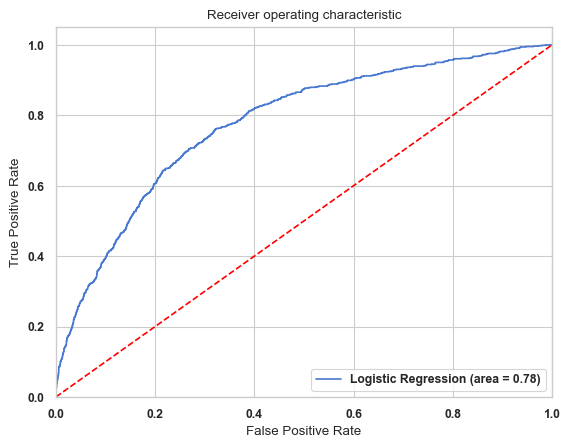

In [ ]:
#roc curve

fpr, tpr, thresholds = roc_curve(y_test_second, y_test_predicted_proba_second)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score_test_second)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

0.23644284226383894

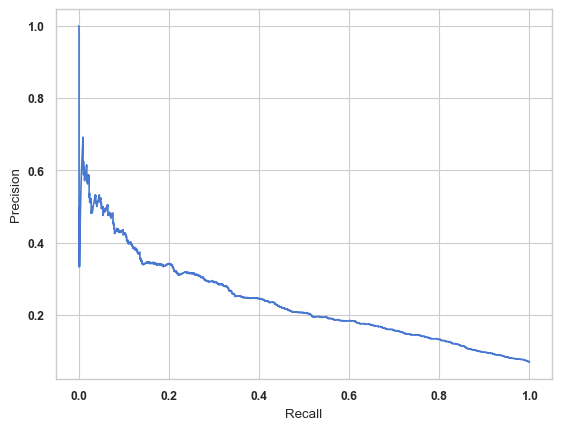

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
precision, recall, thresholds = precision_recall_curve(y_test_first, y_test_predicted_proba_first)
plt.plot(recall, precision)
# вычисление площади методом трапеций from sklearn.metrics import auc

plt.xlabel('Recall')
plt.ylabel('Precision')
auc(recall, precision)

In [ ]:
y_pred = [0.99, 0.31, 0.32, 0.54, 0.67, 0.87]
y_test = [1, 0, 0, 1, 0, 1]
top_k_predictions = np.argsort(y_pred)[-3:]
np.isin(y_test, top_k_predictions)

array([False,  True,  True, False,  True, False])

In [ ]:
def precision_at_k(actual, predicted, k):
    # Ограничение по длине списка до k
    predicted_k = predicted[:k]

    # Подсчет количества правильно предсказанных элементов в топ-k
    correct_count = 0
    for i in range(k):
        if predicted_k[i] in actual:
            correct_count += 1

    # Вычисление precision at k
    precision = correct_count / k
    return precision

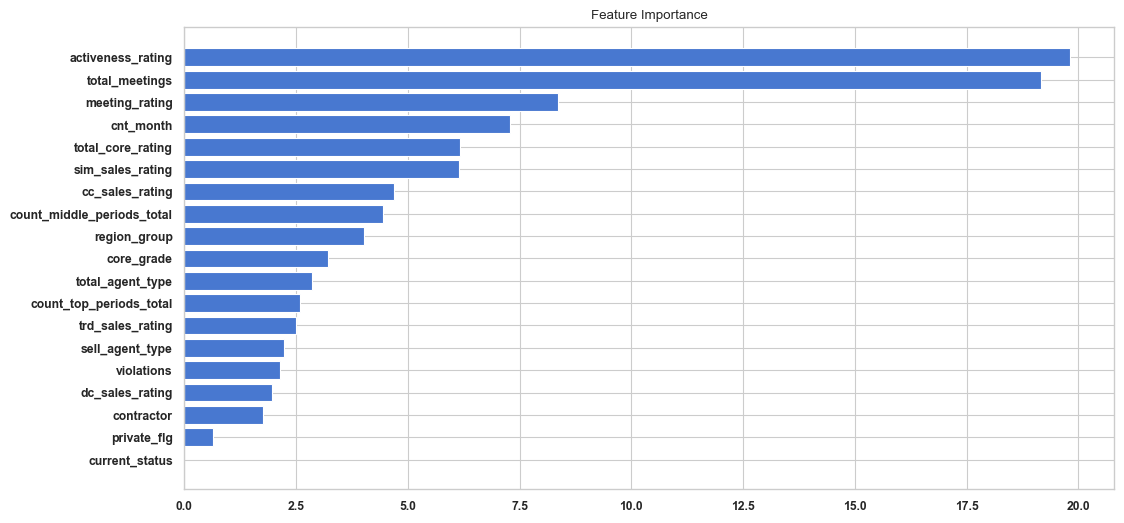

In [ ]:
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool

feature_importance = base_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_first.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [ ]:
# Посмотрим на статистики в разбиении на уволенных и оставшихся
train = pd.read_csv("train.csv")
train[train['status'] == 0].describe()

,id,status,total_meetings,cnt_month,core_grade,total_core_rating,meeting_rating,activeness_rating
count,11039.000000,11039.0,11039.000000,11039.000000,8269.000000,8269.000000,9901.000000,9901.000000
mean,245947.263792,0.0,2322.437902,10.759036,4.398751,62.208462,77.150455,33.566098
std,73420.081054,0.0,3177.256960,13.743051,1.461187,25.064763,8.939576,23.593333
min,1321.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,224681.000000,0.0,191.000000,2.000000,4.831000,45.155500,73.936842,15.541667
50%,268012.000000,0.0,1066.000000,6.000000,4.947500,62.850000,78.681250,29.071429
75%,296356.000000,0.0,3122.000000,14.000000,5.000000,77.005000,82.192593,50.000000
max,339221.000000,0.0,27660.000000,126.000000,5.000000,260.185000,100.000000,100.000000


In [ ]:
train[train['status'] == 1].describe()

,id,status,total_meetings,cnt_month,core_grade,total_core_rating,meeting_rating,activeness_rating
count,128861.000000,128861.0,128861.000000,128861.000000,126338.000000,126338.000000,126343.000000,126343.000000
mean,201295.832362,1.0,5024.832215,18.434639,4.714117,77.917647,80.805981,54.413460
std,89135.615630,0.0,4528.920578,17.235536,0.951492,27.147398,7.749684,25.982509
min,321.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,135302.000000,1.0,1576.000000,6.000000,4.886000,60.756500,77.603333,34.580645
50%,226322.000000,1.0,3856.000000,14.000000,4.947000,77.378000,81.706667,53.846154
75%,271902.000000,1.0,7148.000000,26.000000,4.984500,94.303000,85.461290,75.633333
max,340001.000000,1.0,34474.000000,143.000000,5.000000,283.583000,99.846667,100.000000


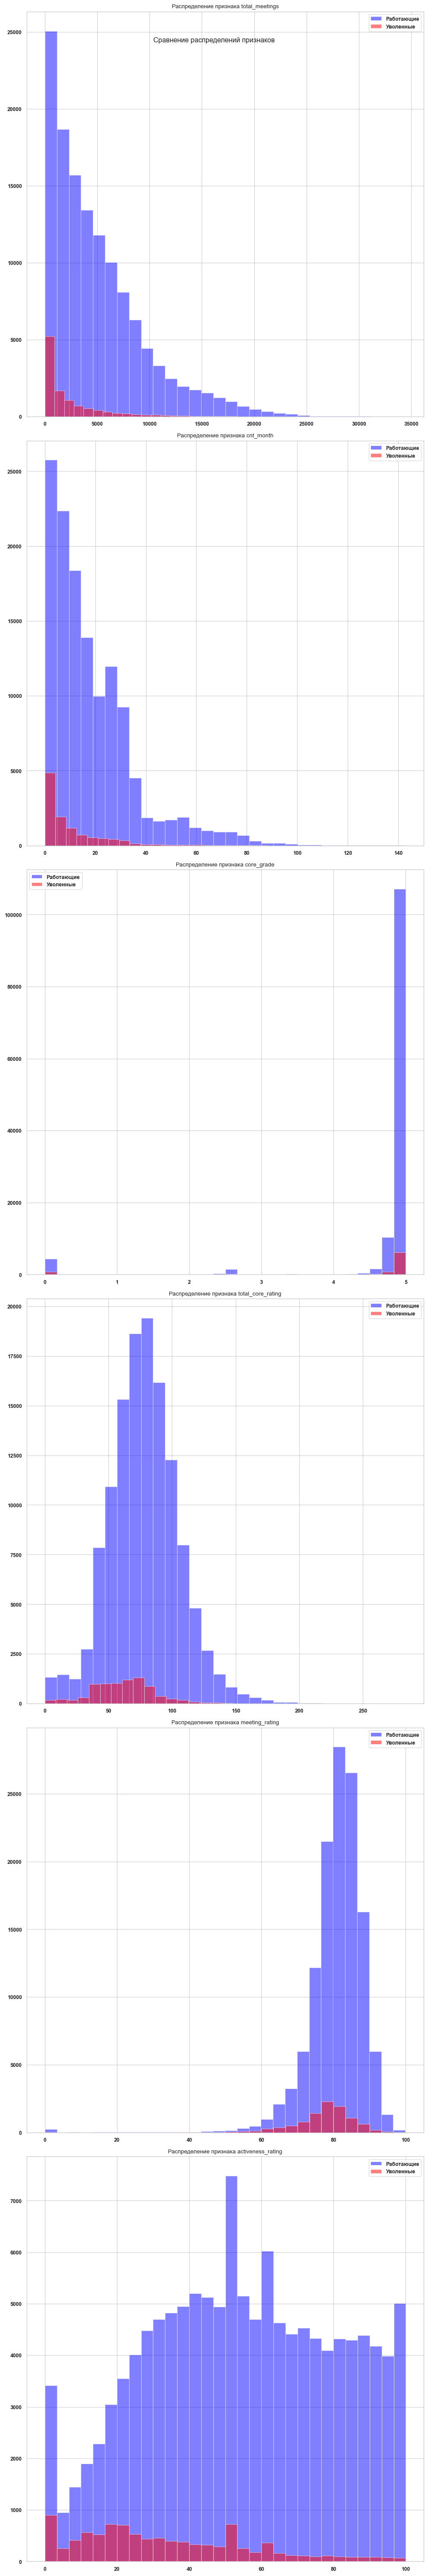

In [ ]:
features_to_compare = ['total_meetings', 'cnt_month', 'core_grade',
                       'total_core_rating', 'meeting_rating', 'activeness_rating']

train = pd.read_csv("train.csv")
fired = train[train['status'] == 0]
not_fired = train[train['status'] == 1]

fig, axes = plt.subplots(len(features_to_compare), 1, figsize=(10, 60))

for i, feature in enumerate(features_to_compare):
    axes[i].hist(not_fired[feature], label='Работающие', color='blue', alpha=0.5, bins=30)
    axes[i].hist(fired[feature], label='Уволенные', color='red', alpha=0.5, bins=30)
    axes[i].set_title(f'Распределение признака {feature}')
    axes[i].legend()

fig.suptitle('Сравнение распределений признаков')
plt.tight_layout()

plt.show()

In [ ]:
%pip install shap
import shap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


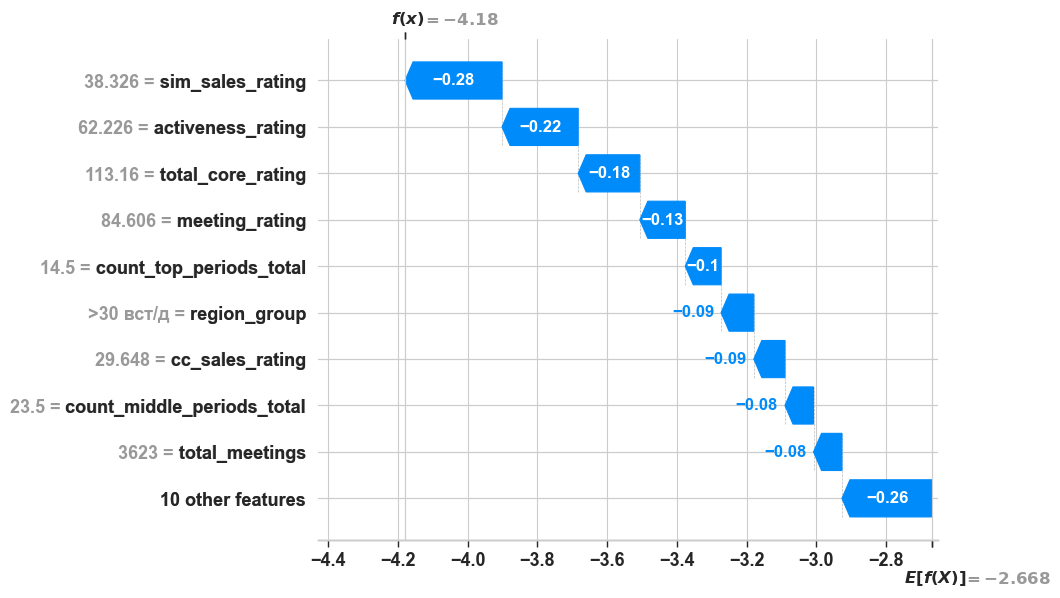

In [ ]:
explainer = shap.Explainer(base_model)
shap_values = explainer(X_test_second)
# X_test_second, X_test_third
shap_values
shap.plots.waterfall(shap_values[4])

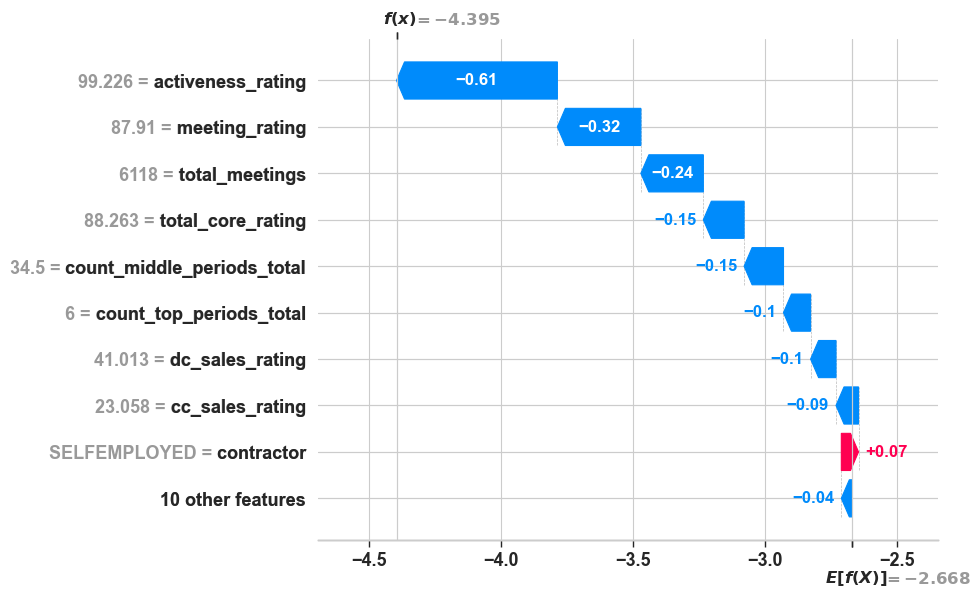

In [ ]:
shap.plots.waterfall(shap_values[0])

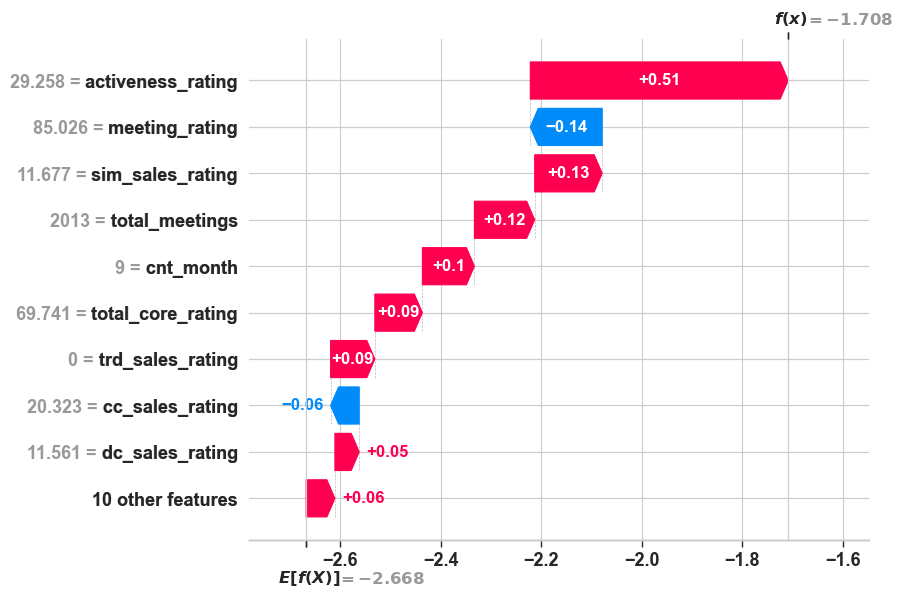

In [ ]:
shap.plots.waterfall(shap_values[2])

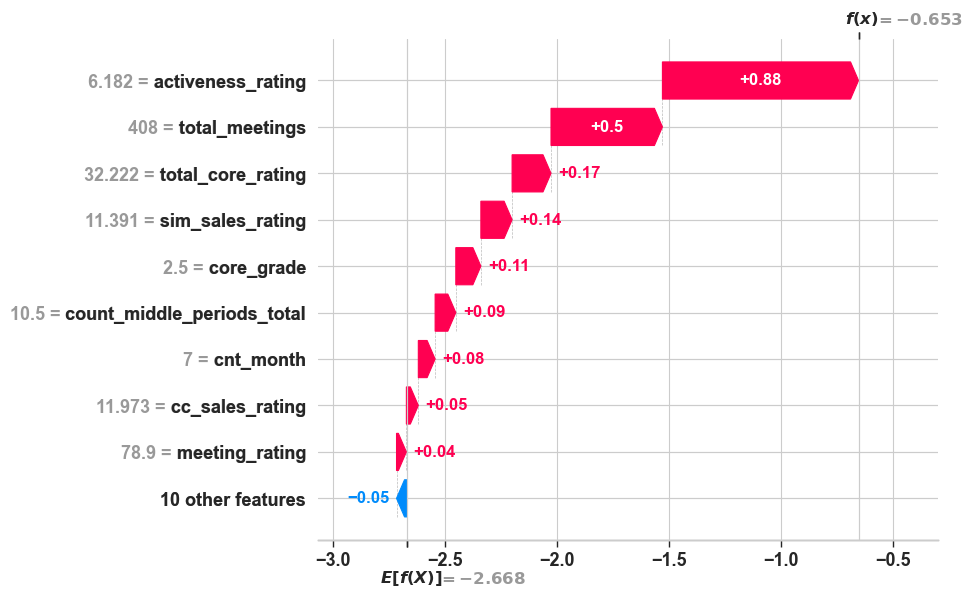

In [ ]:
shap.plots.waterfall(shap_values[5])

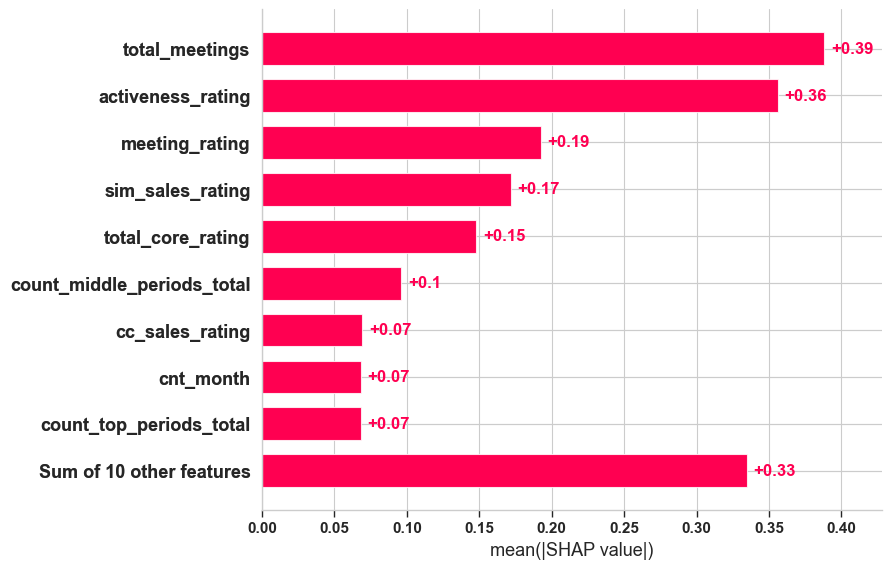

In [ ]:
shap.plots.bar(shap_values)

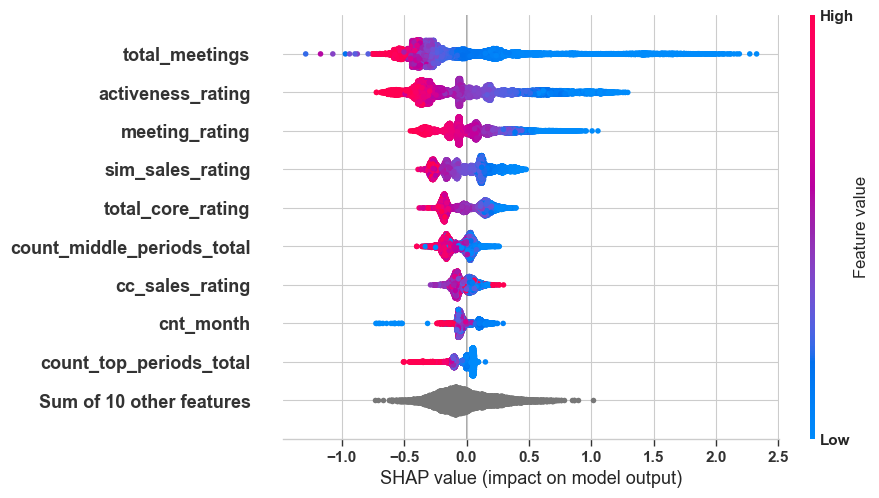

In [ ]:
fig = plt.gcf()
fig.set_size_inches(200, 15)
shap.plots.beeswarm(shap_values)
plt.show()

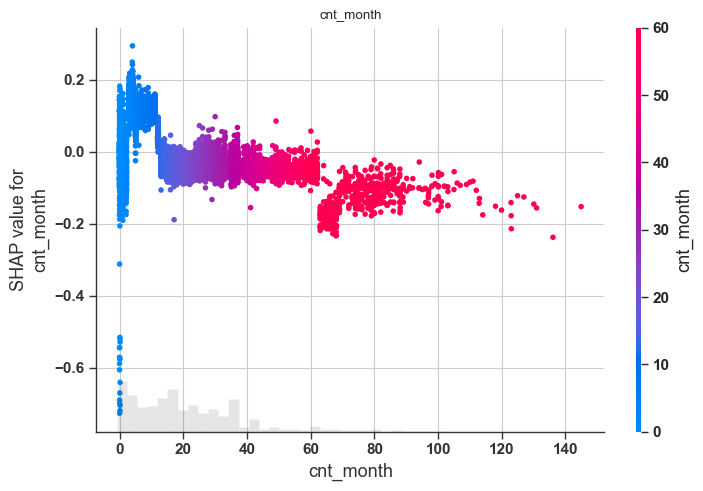

In [ ]:
import shap
import matplotlib.pyplot as plt

shap.plots.scatter(shap_values[:, 2], color=shap_values[:, 2], show=False)
plt.title(X_test_second.columns[2])

plt.tight_layout()
plt.show()

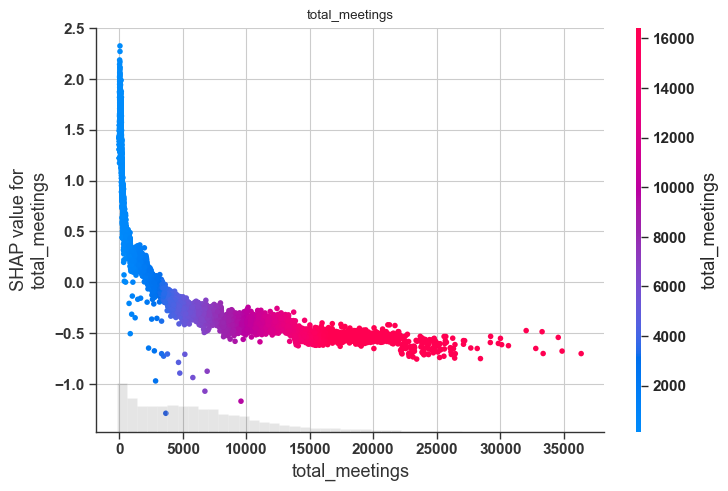

In [ ]:

shap.plots.scatter(shap_values[:, 1], color=shap_values[:, 1], show=False)
plt.title(X_test_second.columns[1])

plt.tight_layout()
plt.show()

Index(['core_grade', 'total_core_rating', 'violations',
       'count_top_periods_total', 'count_middle_periods_total', 'private_flg',
       'meeting_rating', 'activeness_rating', 'cc_sales_rating',
       'dc_sales_rating', 'trd_sales_rating', 'sim_sales_rating'],
      dtype='object')


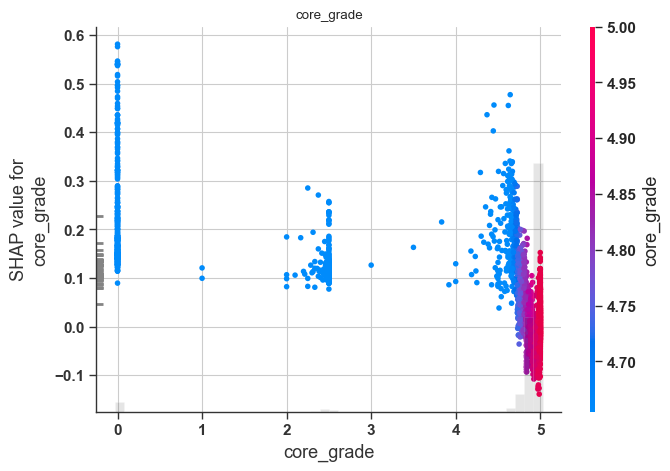

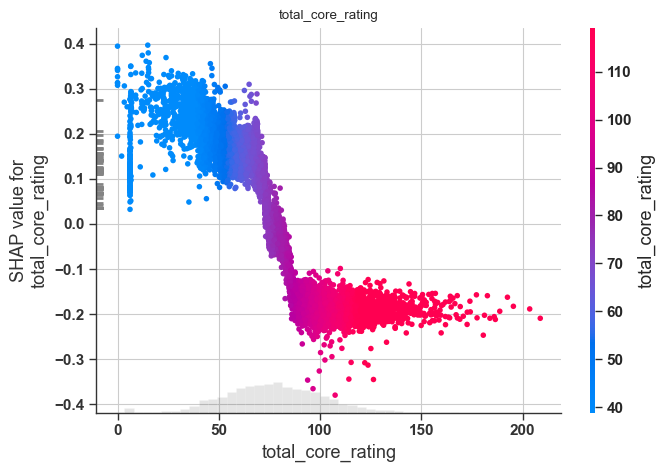

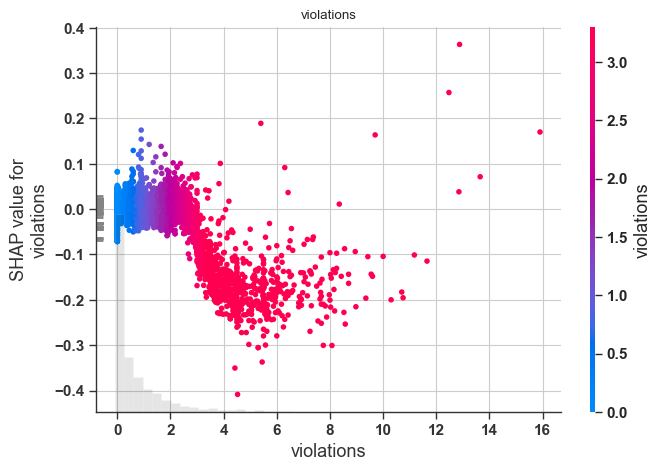

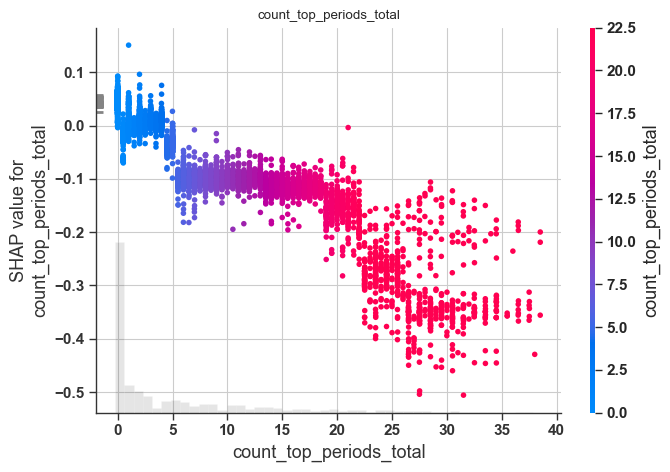

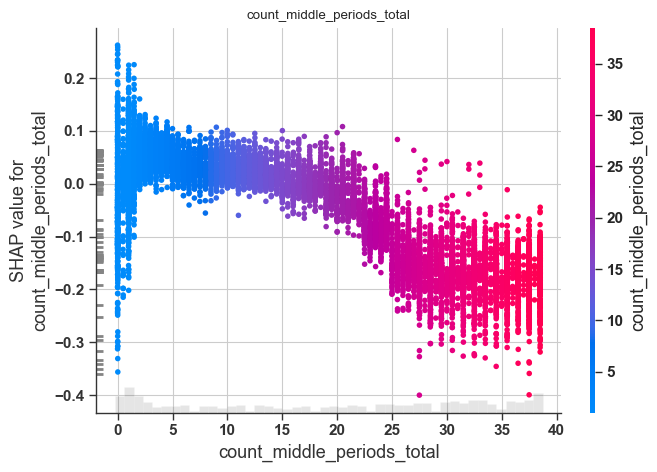

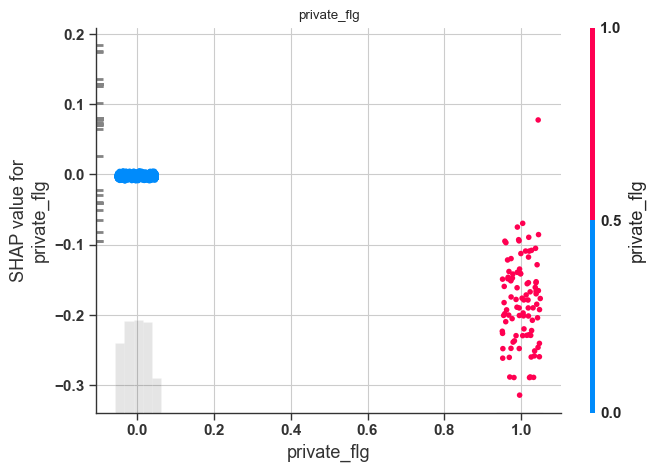

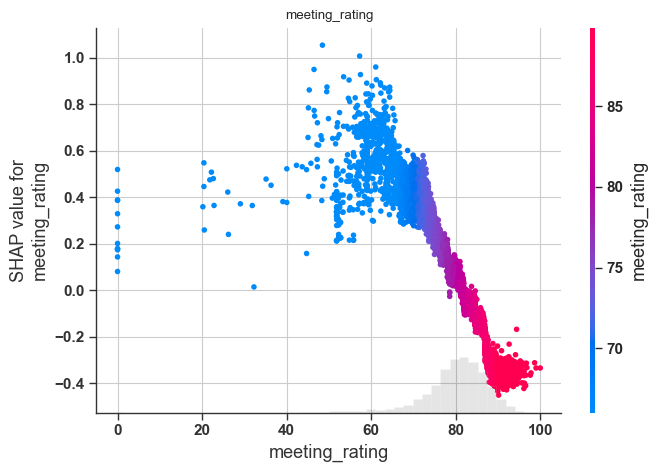

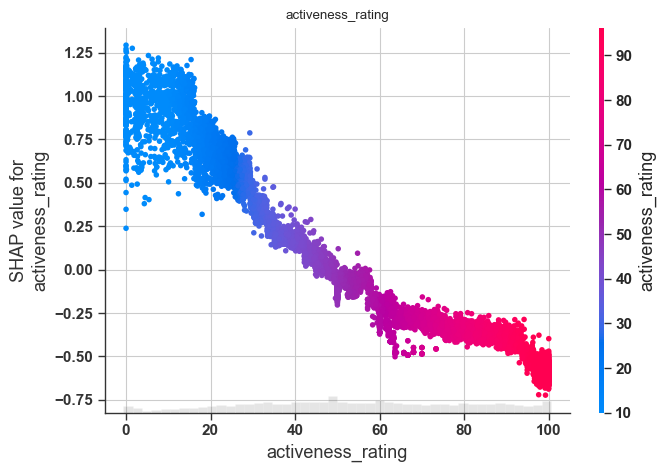

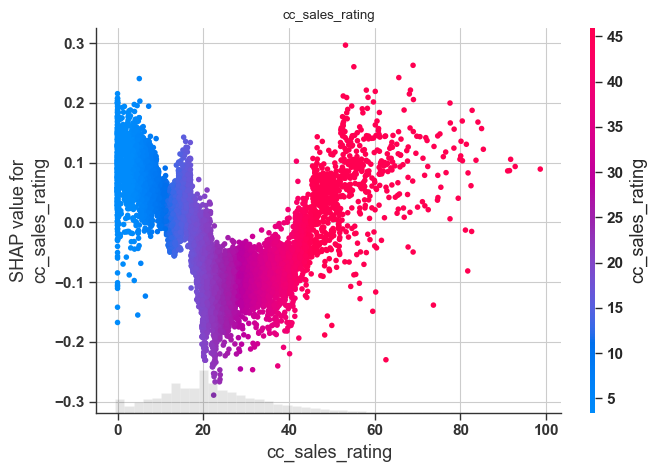

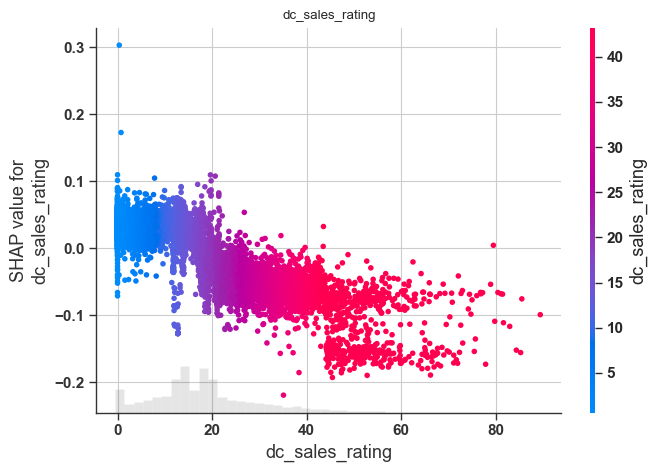

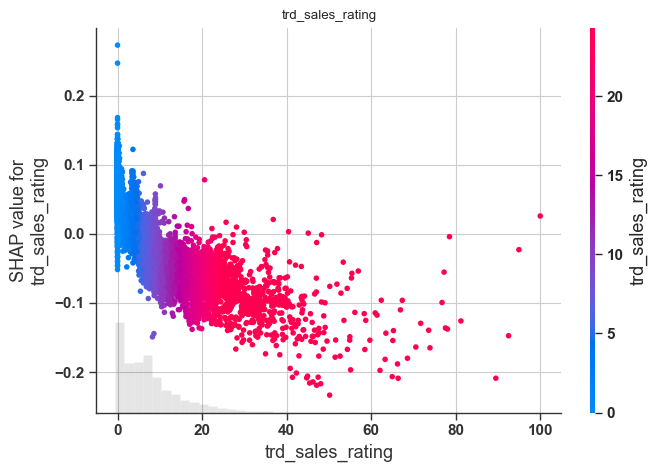

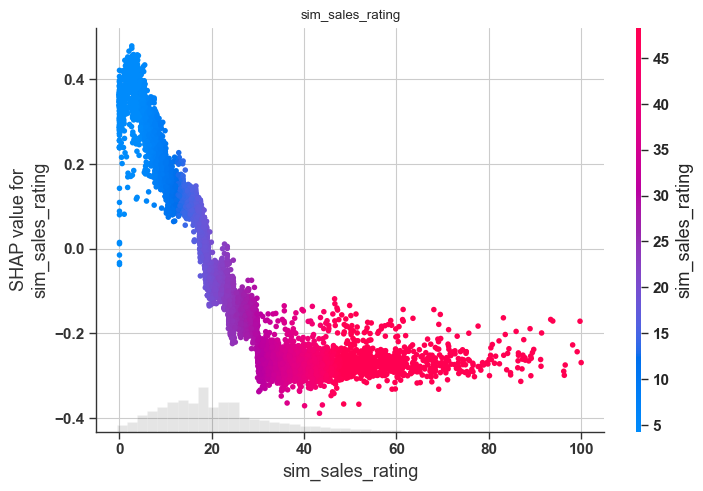

In [ ]:
print(X_test_second.columns[7:])

#fig, axes = plt.subplots(nrows=len(X_test_second.columns[9:]), ncols=1, figsize=(10, 15))

for i in range(7, len(X_test_second.columns)):
    shap.plots.scatter(shap_values[:, i], color=shap_values[:, i], show=False)
    plt.title(X_test_second.columns[i])

plt.tight_layout()
plt.show()

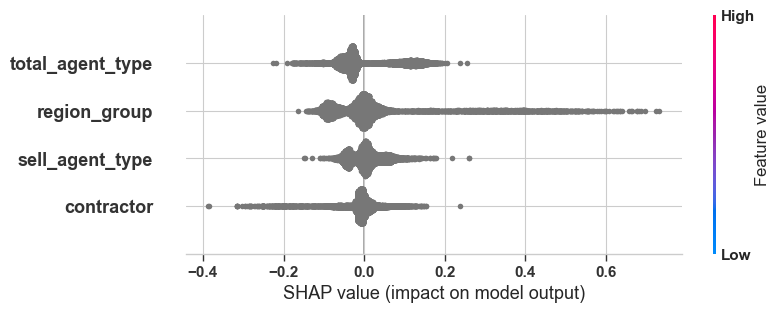

In [ ]:
shap.plots.beeswarm(shap_values[:,3:7])